In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Read Dataset

In [2]:
df = pd.read_csv('/Users/alimustofa/Me/source-code/AI/YoloV8_Pose_Classification/datasets/yoga_pose_keypoint.csv')
df.head()

,image_name,label,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,00000050.jpg,Tree,0.382093,0.257968,0.391399,0.241947,0.372659,0.245997,0.406780,0.254452,...,0.333761,0.558663,0.392117,0.755331,0.250896,0.652156,0.376760,0.935382,0.356965,0.698799
1,00000115.jpg,Tree,0.519270,0.255041,0.532213,0.245500,0.507912,0.246149,0.551442,0.253780,...,0.450827,0.522638,0.431247,0.639775,0.325909,0.628067,0.524197,0.692013,0.483356,0.720042
2,File18.jpg,Tree,0.556664,0.095961,0.584013,0.079112,0.534531,0.080056,0.623709,0.099832,...,0.449697,0.434010,0.558200,0.676735,0.281906,0.593556,0.540054,0.870345,0.548005,0.642861
3,00000015.jpg,Tree,0.532582,0.157779,0.555585,0.138082,0.508886,0.141423,0.593476,0.145060,...,0.437187,0.467791,0.520381,0.710909,0.274717,0.625992,0.511054,0.890891,0.482737,0.641685
4,00000146.jpg,Tree,0.344753,0.345279,0.335593,0.340012,0.346564,0.341552,0.309915,0.352611,...,0.349100,0.605576,0.332953,0.772299,0.408190,0.659132,0.331446,0.897634,0.342666,0.702299


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image_name        1006 non-null   object 
 1   label             1006 non-null   object 
 2   nose_x            1006 non-null   float64
 3   nose_y            1006 non-null   float64
 4   left_eye_x        1006 non-null   float64
 5   left_eye_y        1006 non-null   float64
 6   right_eye_x       1006 non-null   float64
 7   right_eye_y       1006 non-null   float64
 8   left_ear_x        1006 non-null   float64
 9   left_ear_y        1006 non-null   float64
 10  right_ear_x       1006 non-null   float64
 11  right_ear_y       1006 non-null   float64
 12  left_shoulder_x   1006 non-null   float64
 13  left_shoulder_y   1006 non-null   float64
 14  right_shoulder_x  1006 non-null   float64
 15  right_shoulder_y  1006 non-null   float64
 16  left_elbow_x      1006 non-null   float64


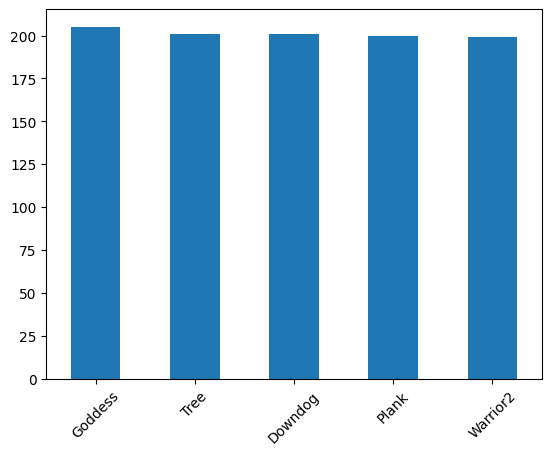

In [4]:
df.label.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

## Train Test Split

In [5]:
# encoder label
encoder = LabelEncoder()
y_label = df['label']
y = encoder.fit_transform(y_label)
y

array([3, 3, 3, ..., 4, 4, 4])

In [6]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights

array([1.00099502, 0.98146341, 1.006     , 1.00099502, 1.01105528])

In [7]:
# Get keypoint dataset
X = df.iloc[:,12:]
X

,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0.424617,0.342608,0.336943,0.335260,0.451014,0.233721,0.315634,0.208830,0.460854,0.118578,...,0.333761,0.558663,0.392117,0.755331,0.250896,0.652156,0.376760,0.935382,0.356965,0.698799
1,0.589480,0.315508,0.453138,0.310921,0.651657,0.227197,0.376035,0.220531,0.533466,0.176462,...,0.450827,0.522638,0.431247,0.639775,0.325909,0.628067,0.524197,0.692013,0.483356,0.720042
2,0.693609,0.219494,0.417954,0.224509,0.776201,0.296287,0.322378,0.307532,0.600253,0.265993,...,0.449697,0.434010,0.558200,0.676735,0.281906,0.593556,0.540054,0.870345,0.548005,0.642861
3,0.660799,0.260707,0.413654,0.270484,0.729965,0.385931,0.362548,0.395031,0.596187,0.346363,...,0.437187,0.467791,0.520381,0.710909,0.274717,0.625992,0.511054,0.890891,0.482737,0.641685
4,0.296271,0.402245,0.360647,0.407716,0.289721,0.299633,0.369867,0.305831,0.315140,0.219617,...,0.349100,0.605576,0.332953,0.772299,0.408190,0.659132,0.331446,0.897634,0.342666,0.702299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,0.467357,0.353031,0.601015,0.340104,0.349533,0.329071,0.730516,0.351984,0.255759,0.318375,...,0.597950,0.583271,0.369833,0.764038,0.741054,0.688727,0.198313,0.869421,0.808196,0.896311
1002,0.552082,0.425189,0.424876,0.415166,0.673358,0.442493,0.307205,0.436388,0.768636,0.447744,...,0.425132,0.637139,0.658695,0.728822,0.302627,0.670267,0.771475,0.827222,0.302183,0.833196
1003,0.632437,0.330302,0.547641,0.335805,0.717520,0.340644,0.457332,0.339002,0.792252,0.307535,...,0.544859,0.549379,0.706932,0.609090,0.472401,0.656969,0.704039,0.766374,0.368973,0.776699
1004,0.574252,0.332210,0.460697,0.333081,0.692204,0.319768,0.337144,0.367445,0.801876,0.301595,...,0.460548,0.629266,0.727626,0.748592,0.318314,0.677710,0.858627,0.867028,0.287129,0.909058


In [10]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=2022)

print("Number of Training keypoints: ", len(X_train))
print("Number of Testing keypoints: ", len(X_test))

Number of Training keypoints:  804
Number of Testing keypoints:  202


In [11]:
scaler = MinMaxScaler()

In [12]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test

array([[0.34417519, 0.45682809, 0.48793906, ..., 0.41314268, 0.85394964,
        0.37971661],
       [0.42936592, 0.38853424, 0.30138805, ..., 0.76699598, 0.31581737,
        0.52902319],
       [0.46941772, 0.37319336, 0.40830071, ..., 0.85820996, 0.31094469,
        0.73058033],
       ...,
       [0.57503495, 0.74992333, 0.61749294, ..., 0.53610928, 0.18082212,
        0.59679452],
       [0.44632282, 0.57576281, 0.56673229, ..., 0.56851392, 0.88023296,
        0.57052194],
       [0.76320104, 0.83342996, 0.77454371, ..., 0.67456042, 0.05807365,
        0.68143423]])

## Data Loader

In [13]:
class DataKeypointClassification(Dataset):
    def __init__(self, X, y):
        self.x = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.int64))
        self.n_samples = X.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

In [14]:
train_dataset = DataKeypointClassification(X_train, y_train)
test_dataset = DataKeypointClassification(X_test, y_test)

In [20]:
batch_size = 12
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Model

In [26]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

In [27]:
hidden_size = 256
model = NeuralNet(X_train.shape[1], hidden_size, len(class_weights))

In [28]:
len(class_weights)

5

## Loss & Optimizer

In [29]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights.astype(np.float32)))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [30]:
num_epoch = 40
for epoch in range(num_epoch):
    train_acc = 0
    train_loss = 0
    loop = tqdm(train_loader)
    for idx, (features, labels) in enumerate(loop):
        outputs = model(features)
        loss = criterion(outputs, labels)

        predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
        correct = (predictions == labels).sum().item()
        accuracy = correct / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch}/{num_epoch}]")
        loop.set_postfix(loss=loss.item(), acc=accuracy)


Epoch [39/40]: 100%|██████████| 67/67 [00:00<00:00, 207.97it/s, acc=0.917, loss=0.123] 


## Test Model

In [31]:
test_features = torch.from_numpy(X_test.astype(np.float32))
test_labels = y_test
with torch.no_grad():
    outputs = model(test_features)
    _, predictions = torch.max(outputs, 1)
predictions

tensor([0, 3, 4, 0, 2, 0, 3, 4, 3, 3, 1, 4, 0, 1, 1, 1, 0, 2, 2, 1, 3, 1, 0, 2,
        3, 4, 4, 4, 3, 3, 2, 1, 3, 4, 1, 2, 3, 1, 3, 0, 1, 4, 1, 3, 1, 0, 0, 1,
        0, 3, 1, 2, 1, 3, 3, 0, 0, 2, 0, 3, 0, 3, 1, 0, 3, 0, 4, 0, 1, 1, 0, 4,
        2, 0, 4, 1, 4, 1, 3, 1, 3, 2, 4, 4, 2, 0, 0, 2, 0, 4, 4, 1, 2, 3, 4, 1,
        0, 0, 3, 4, 1, 3, 0, 1, 2, 1, 0, 1, 2, 1, 0, 4, 4, 3, 3, 2, 4, 3, 2, 0,
        3, 4, 4, 1, 3, 4, 1, 1, 1, 2, 0, 3, 0, 4, 4, 0, 1, 0, 1, 3, 0, 1, 3, 3,
        4, 3, 1, 3, 3, 1, 1, 3, 1, 4, 0, 2, 4, 1, 2, 3, 3, 4, 4, 4, 4, 3, 2, 3,
        3, 4, 0, 3, 3, 3, 2, 2, 3, 2, 1, 2, 0, 1, 2, 0, 2, 2, 1, 0, 4, 1, 4, 4,
        1, 0, 3, 1, 3, 2, 2, 0, 0, 2])

In [32]:
print(classification_report(test_labels, predictions, target_names=encoder.classes_))

              precision    recall  f1-score   support

     Downdog       0.95      0.97      0.96        40
     Goddess       0.85      0.95      0.90        41
       Plank       1.00      0.78      0.87        40
        Tree       0.83      0.95      0.89        41
    Warrior2       0.95      0.88      0.91        40

    accuracy                           0.91       202
   macro avg       0.91      0.91      0.91       202
weighted avg       0.91      0.91      0.91       202



In [33]:
cm = confusion_matrix(test_labels, predictions)
df_cm = pd.DataFrame(
    cm, 
    index = encoder.classes_,
    columns = encoder.classes_
)
df_cm

,Downdog,Goddess,Plank,Tree,Warrior2
Downdog,39,1,0,0,0
Goddess,1,39,0,1,0
Plank,1,0,31,7,1
Tree,0,1,0,39,1
Warrior2,0,5,0,0,35


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


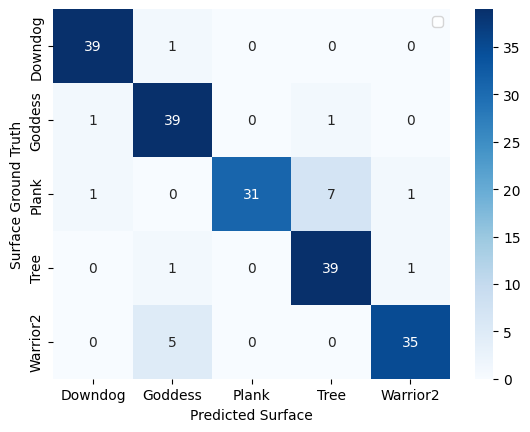

In [34]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.ylabel("Surface Ground Truth")
    plt.xlabel("Predicted Surface")
    plt.legend()
    
show_confusion_matrix(df_cm)

## save model


In [35]:
PATH_SAVE = '/Users/alimustofa/Me/source-code/AI/YoloV8_Pose_Classification/models/pose_classification.pt'
torch.save(model.state_dict(), PATH_SAVE)

## Load Inference Model

In [36]:
model_inference =  NeuralNet(
        X_train.shape[1], 
        hidden_size, 
        len(class_weights)
    )

model_inference.load_state_dict(
        torch.load(PATH_SAVE, map_location=device)
    )

<All keys matched successfully>

In [41]:
feature, label = test_dataset.__getitem__(51)

out = model_inference(feature)
_, predict = torch.max(out, -1)
print(f'\
    prediction label : {encoder.classes_[predict]} \n\
    ground thrut label : {encoder.classes_[label]}'
    )

    prediction label : Plank 
    ground thrut label : Plank


In [133]:
encoder.classes_

array(['Downdog', 'Goddess', 'Plank', 'Tree', 'Warrior2'], dtype=object)